<a href="https://colab.research.google.com/github/erickmu1/Image-Segmentation/blob/E/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360: Image Segmentation #

### **Team 5** ###
- Bonnie He
- Erick Mejia Uzeda
- Hannah Lee

## Project Description ##

TODO

# Imports + Global Variables #

Here we import all required libraries and define any useful variables.

In [36]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Math
import numpy as np
import matplotlib.pyplot as plt

# Data storage/loading
import os
import pickle
from google.colab import drive

# Global Variables
DRIVE_ROOT = '/content/drive'
COLAB_ROOT = 'My Drive/Colab Notebooks'

ROOT = os.path.join(*[ DRIVE_ROOT, COLAB_ROOT, 'Image-Segmentation' ])

BACKGROUND_ID = -1  # TODO: actually determine a unique ID for 'background'
MAX_LABELS = 16     # Maximum number of labels we will keep
IN_CHANNELS = 4     # RGBD images have 4 channels
IN_DIM = (530, 730) # Dimensions of RGBD images

In [ ]:
# Link to Google Drive
drive.mount(DRIVE_ROOT)

Mounted at /content/drive


# Data Loading #

In [ ]:
# Code for loading data

# Data Pre-processing #

## Pre-computing Features from other ML models ##

We may have parts of the full ML pipeline implemented and others not. To speed up the training process, it is beneficial to precompute features resulting from a model and save them.

**Note:** Features are saved in such a format that once re-loaded, they can be passed directly into a `DataLoader`.

In [ ]:
# Compute and Save Features from 'model'
def save_features(model, data_loader, file_name, dir=ROOT, use_cuda=False):
  features = []

  for input, label in data_loader:
    # Enable CUDA
    if use_cuda and torch.cuda.is_available():
      input = input.cuda()
      label = label.cuda()
    
    # Compute features
    with torch.no_grad():
      output = model(input)

    # Cache resulting features
    features.extend(output.cpu())
  
  # Save computed features using pickle
  save_path = os.path.join(dir, file_name + '.pickle')

  with open(save_path, 'wb+') as f:
    pickle.dump(features, f)

In [ ]:
# Load features
def load_features(file_name, dir=ROOT):
  file_path = os.join.path(dir, file_name + '.pickle')

  # Load features using pickle
  with open(file_path, 'rb') as f:
    features = pickle.load(f)
  
  return features

## Grouping Background Segments ##

Our dataset has many labels for different categories. Since our goal is to segment non-background items that are *distinct*, we will pre-process the raw segmentation maps to group relevant labels/categories that could be considered as *background*.

The following are grouped together: (Background)
- `floor`
- `wall`
- `ceiling`
- `window`

In [ ]:
# Group all 'background' segments into one category
def group_background(seg_maps):
  # ASSUME: seg_maps is a np.array with dimensions (num_samples x [image_dims])
  # NOTE: this function modifies seg_maps itself!

  relevant_labels = [ 'floor', 'wall', 'ceiling', 'window' ]
  relevant_ids = [ 0, 1, 2, 3 ]  # TODO: get *actual* numerical IDs

  # Retrieve indices (pixels) of relevant labels
  indices = np.isin(seg_maps, relevant_ids)
  
  # Associate such indices (pixels) as 'background'
  seg_maps[indices] = BACKGROUND_ID

## Dealing with Label Permutation and Number of Segments ##

Our model will not particularly care what label is associated to segments, hence we prefer to refer to a segment by its segment ID. To re-iterate, our model does not care about what the value of the segment ID is for any given segment, what will dictate if our model is working if it can properly distinguish two **distinct** segments. Thus given an outputted segmentation map, any same segmentation map but with the segment IDs permutted is equally valid. Moreover, our model (in theory) should be invariant to more than permutation, that is any value can be assigned to a segment, as long as distinct segments have distinct IDs.

Next, the number of segments depends generally on the number of objects in the scene, so it not known a priori for new samples. This suggests the use of a recurrent architecture but once again, the order in which the segments would be generated is not of importance. In general, dealing with a variable number of possible segments must be accounted for in the model!

### Ideas: ###

- Use a permutation invariant loss function:https://openreview.net/pdf?id=rJxpuoCqtQ
  - A major issue is that the number of segments produced for an image is not fixed, whereas this paper assumes the number of features `F` is known.
  - Should we not upper bound the outputs and round each pixel value to the nearest integer as to define its *segment ID*? How sensitive to small weight variantions would our model be? How dependent on the segment ID values temselves will the model be?
- Should we use a Recurrent Architecture?
  - That is: for each image
    1. extract the "largest" label
    2. remove all pixels from input that correspond to the segment meant to be removed
    3. feed in new image and repeat from step 1.
  - Note that we will need to either pre-process many images during training (which will make it slow) or cache multiple variants of an image which remove one segment at a time (can grow large if image has many segments)
    - Also need to pre-process and "order" segments by how "big" they are (need to compute pixel area of each segment and order them before making "inputs" that have the relevant segments removed)
  - We could possibly apply a *Recurrent Pipeline* to our baseline model (k-means) too!
- Say we generate all segments from the image in one-pass of the model (simple autoencoder architecture)
  - How do we deal with segment ID permutations (and even just different IDs in general, as long as the correct distinct segments have distinct IDs)?
  - How do we encode each segment ID?

**KEY IDEA:** What if we followed the convention that the largest segment (other than the background) must have the largest (smallest?) ID? Could this additional rule be learned by the model?
- If yes, then we resolved the issue of segment ID permutation
  - What happens for segments of comparable size? (to think about later)
- Could we then also apply *integer thresholding* (or some other thresholding) to identify each distinct segment? This would avoid the need to use a recurrent architecture

### Sorting Segments by Size ###

To address the issues outlined above of the semantic associated with each segment's label and permutation (or the only necessary distinctness requirement) of each segment label, we will sort segments from largest to smallest. The following convention will be assumed and our hope is that the machine learning model can learn this rule:
- Background ~ `label = 0`
- Largest Segment ~ `label = 1`
- Second Largest Segment ~ `label = 2`
- `...`

In [ ]:
# ASSUME: relevant labels have been grouped into BACKGROUND_ID
def sort_segments_by_size(seg_map, max_labels=np.infty):
  # Get list of segment labels found in the image
  old_labels = np.unique(seg_map)

  # Count the number of pixels for each segment
  pixel_count = { label : 0 for label in old_labels }

  for r in range(seg_map.shape[0]):
    for c in range(seg_map.shape[1]):
      pixel_count[seg_map[r,c]] += 1

  # Special case: background must always have the largest pixel count as to
  # enforce background label = 0
  if BACKGROUND_ID in pixel_count:
    pixel_count[BACKGROUND_ID] = np.infty
  else:
    print('No Background in Segmentation Map - Did you forget to pre-process?')
  
  # Sort by pixel count
  sorted_labels = sorted(pixel_count, key=lambda label: pixel_count[label], reverse=True)

  # Keep only the max_lables largest labels
  sorted_labels = sorted_labels[:min(max_labels, len(sorted_labels))]
  new_labels = { old_label: new_label for (new_label, old_label) in enumerate(sorted_labels) }
  
  # Create new segmentation map using new labels
  sorted_seg_map = np.zeros(seg_map.shape)

  for r in range(seg_map.shape[0]):
    for c in range(seg_map.shape[1]):
      sorted_seg_map[r,c] = new_labels[seg_map[r,c]]
  
  return sorted_seg_map

No Background in Segmentation Map - Did you forget to pre-process?


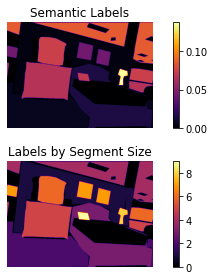

In [ ]:
# TEST
seg_map = plt.imread(os.path.join(ROOT, 'Data/img-000007.png'))
fig, axs = plt.subplots(2)

# Plot input image (semantic labels)
mappable = axs[0].imshow(seg_map, cmap='inferno')
axs[0].set_title('Semantic Labels')
axs[0].axis('off')
fig.colorbar(mappable, ax=axs[0])

sorted_map = sort_segments_by_size(seg_map)

# Plot output image (labels by segment size)
mappable = axs[1].imshow(sorted_map, cmap='inferno')
axs[1].set_title('Labels by Segment Size')
axs[1].axis('off')
fig.colorbar(mappable, ax=axs[1]);

plt.tight_layout()

## Data Augmentation (Optional) ##

See if we can apply homographies on RGBD + ground truth segmentation map and if we can add noise to the RGBD images.

In [ ]:
# Code for homographic transformation

In [ ]:
# Code for adding noise to {RGB, Depth}

# Baseline model: k-means Algorithm #

In [ ]:
# Code for k-means algorithm

# Training Pipeline #

In [ ]:
# Code for the training pipeline

## Compute Accuracy ##

Computes accuracy of a model given a `DataLoader`. Note that the notion of accuracy is not straightforward for tasks other than classification and thus must handled with care as we attempt to quantify how well our models perform!

In [ ]:
def get_classifier_accuracy(model, data_loader, use_cuda=False):
  correct, total = 0, 0

  for inputs, targets in data_loader:
    # Enable CUDA
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    # Compute prediction
    outputs = model(inputs)
    preds = outputs.max(1, keepdim=True)[1]

    # Tally
    correct += preds.eq(targets.view_as(preds)).sum().item()
    total += inputs.size(0)
  
  return float(correct) / total

## Train Models ##

The training pipeline is rather consistent among feedforward classifier models. Functions for training will wrap extra desired functionality to accomodate model requirements.

**TODO:** Wrap common iteration loops in a function, allowing customizations where needed (e.g. running a model through a data_loader is a very common process and we can pass in custom functions to extract relevant data, pre-process [add noise], optionally computing accuracy and such).

**TODO:** Wrap plotting functions for training curves.

In [ ]:
# TODO: add model defined hyperparameters
def model_path(model, batch_size, learning_rate, epoch, root=''):
  path = 'model_{0}_bs{1}_lr{2}_epoch{3}'.format(model.name,
                                                 batch_size,
                                                 learning_rate,
                                                 epoch)
  return os.path.join(dir, path)

In [ ]:
def train_classifier(model, train_loader, val_loader, use_cuda=False, 
                     learning_rate=1e-3, num_epochs=20):
  torch.manual_seed(1000)

  # Optimization settings
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Cache loss/accuracy
  train_loss, val_loss = [], []
  train_acc, val_acc = [], []

  print('Training Start!')

  for epoch in range(num_epochs):
    ### TRAIN model ###
    running_loss = 0

    for inputs, targets in train_loader:
      # Enable CUDA
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # Update running loss
      running_loss += loss.item() * inputs.size(0)
    
    train_loss.append(running_loss / len(train_loader.dataset))

    ### Compute VALIDATION loss ###
    running_loss = 0

    for inputs, targets in val_loader:
      # Enable CUDA
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      # Forward pass
      with torch.no_grad():
        outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Update running loss
      running_loss += loss.item() * inputs.size(0)
    
    val_loss.append(running_loss / len(val_loader.dataset))

    # Compute accuracy
    train_acc.append(get_classifier_accuracy(model, train_loader, use_cuda))
    val_acc.append(get_classifier_accuracy(model, val_loader, use_cuda))

    print('Epoch {} (accuracy): {} train, {} val'.format(epoch, train_acc[-1], val_acc[-1]))

    # Checkpoint model
    # Q: do we want to save checkpoints to our Drive?
    path = model_path(model, train_loader.batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), path)

  ### Plot Training Curves ###
  fig, axs = plt.subplots(2)

  # Loss
  axs[0].plot(train_loss)
  axs[0].plot(val_loss)

  axs[0].legend(('Train', 'Validation'))
  axs[0].set_title('Train / Validation Loss')
  axs[0].set(xlabel='Epochs', ylabel='Loss')

  # Accuracy
  axs[1].plot(train_acc)
  axs[1].plot(val_acc)

  axs[1].legend(('Train', 'Validation'))
  axs[1].set_title('Train / Validation Accuracy')
  axs[1].set(xlabel='Epochs', ylabel='Accuracy')

  plt.tight_layout()

Autoencoders have a slightly different pipeline and can be adjusted to improve robustness.

In [83]:
# Train AutoEncoder that produces Segmentation Maps
# NOTE: Each pixel of the Segmentation Map is a one-hot encoding
def train_autoencoder(model, train_loader, val_loader, use_cuda=False, 
                     learning_rate=1e-3, num_epochs=20):
  torch.manual_seed(1000)

  # Optimization settings
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Cache loss
  # TODO: add accuracy
  train_loss, val_loss = [], []

  print('Training Start!')

  for epoch in range(num_epochs):
    ### TRAIN model ###
    running_loss = 0

    for inputs, _ in train_loader:
      # TODO: enable input pre-processing (e.g. add noise)
      # Enable CUDA
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
      
      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs.view(-1, MAX_LABELS), inputs.view(-1,1).squeeze())

      # Backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # Update running loss
      running_loss += loss.item() * inputs.size(0)
    
    train_loss.append(running_loss / len(train_loader.dataset))

    ### Compute VALIDATION loss ###
    running_loss = 0

    for inputs, _ in val_loader:
      # TODO: enable input pre-processing (e.g. add noise)
      # Enable CUDA
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
      
      # Forward pass
      with torch.no_grad():
        outputs = model(inputs)
      loss = criterion(outputs.view(-1, MAX_LABELS), inputs.view(-1,1).squeeze())

      # Update running loss
      running_loss += loss.item() * inputs.size(0)
    
    val_loss.append(running_loss / len(val_loader.dataset))

    print('Epoch {} (loss): {} train, {} val'.format(epoch, train_loss[-1], val_loss[-1]))

    # Checkpoint model
    # Q: do we want to save checkpoints to our Drive?
    path = model_path(model, train_loader.batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), path)

  ### Plot Training Curves ###
  plt.plot(train_loss)
  plt.plot(val_loss)

  plt.legend(('Train', 'Validation'))
  plt.title('Train / Validation Loss')
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

# Model Implementation #

## Construct Segmentation Maps using a Convolutional Autoencoder ##

This model is not strictly a convolutional autoencoder, since we will compare our reconstructed output to the corresponding segmentation map and not the input RGBD image.

**NOTE:**
- Input size is `(4, 530, 730)`
- Output size is `(MAX_LABELS, 530, 730)`

In [39]:
### Helper Functions ###

# Ensures a Convolution Layer is fully specified
def get_conv_dict(in_channels, out_channels, kernel_size, stride=1, padding=0):
  conv_dict = {
      'i': in_channels,
      'o': out_channels,
      'k': kernel_size,
      's': stride,
      'p': padding
  }
  return conv_dict

# Ensures a Transpose Convolution Layer is fully specified
def get_convT_dict(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
  convT_dict = {
      'i': in_channels,
      'o': out_channels,
      'k': kernel_size,
      's': stride,
      'p': padding,
      'op': output_padding
  }
  return convT_dict

# Given input/output and conv layers, compute transpose conv layers
def get_convT_layers(conv_layers, image_size=IN_DIM, output_channels=MAX_LABELS, print_Fmaps=False):
  # Cache the size / dimension (w x h) of each intermediate feature map
  fmaps = [ image_size ]

  # Compute feature map dimensions after each convolutional layer
  for layer in conv_layers:
    w_in, h_in = fmaps[-1]
    
    w_out = (w_in + 2 * layer['p'] - layer['k']) // layer['s'] + 1
    h_out = (h_in + 2 * layer['p'] - layer['k']) // layer['s'] + 1

    fmaps.append((w_out, h_out))
  
  if print_Fmaps:
    print('Feature Maps (w,h):', fmaps)
  
  # Reverse lists for decoding
  rev_fmaps = list(reversed(fmaps))
  rev_conv_layers = list(reversed(conv_layers))

  # Determine appropriate transpose convolution layers
  convT_layers = []

  for idx in range(len(rev_conv_layers)):
    # Get relevant parameters
    layer = rev_conv_layers[idx]

    fmap_in = rev_fmaps[idx]
    fmap_out = rev_fmaps[idx + 1]

    w_in, h_in = fmap_in
    w_out, h_out = fmap_out

    # Compute required output padding
    w_pout = w_out - layer['s'] * (w_in - 1) + 2 * layer['p'] - layer['k']
    h_pout = h_out - layer['s'] * (h_in - 1) + 2 * layer['p'] - layer['k']

    # Append associated transpose convolutional layer
    convT_layers.append(get_convT_dict(in_channels=layer['o'], out_channels=layer['i'],
                                       kernel_size=layer['k'], stride=layer['s'], 
                                       padding=layer['p'], output_padding=(w_pout, h_pout)))
  
  # Ensure last layer outputs specified number of channels
  convT_layers[-1]['o'] = output_channels

  return convT_layers

In [45]:
### Encoder (RBGD --> Embedding) ###

class ConvE(nn.Module):
  def __init__(self, conv_layers):
    super(ConvE, self).__init__()
    self.name = 'convE'
    self.layers = []

    # Create Architecture
    for layer in conv_layers:
      self.layers.append(nn.Conv2d(in_channels=layer['i'], out_channels=layer['o'],
                                   kernel_size=layer['k'], stride=layer['s'], 
                                   padding=layer['p']))

  def forward(self, x):
    for layer in self.layers:
      x = F.relu(layer(x))

    return x

### Decoder (Embedding --> MAX_LABELS one-hot encoding per pixel of RGBD) ###

class ConvD(nn.Module):
  def __init__(self, convT_layers):
    super(ConvD, self).__init__()
    self.name = 'convD'
    self.layers = []

    for layer in convT_layers:
      self.layers.append(nn.ConvTranspose2d(in_channels=layer['i'], out_channels=layer['o'],
                                            kernel_size=layer['k'], stride=layer['s'],
                                            padding=layer['p'], output_padding=layer['op']))

  def forward(self, x):
    # Do not apply ReLU on last layer
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))

    # NOTE: assume will use BCEWithLogitsLoss (do not apply sigmoid)
    return self.layers[-1](x)

### Convolutional "Autoencoder" ###

class ConvAE(nn.Module):
  def __init__(self, conv_layers, image_size=IN_DIM, out_channels=MAX_LABELS):
    super(ConvAE, self).__init__()
    self.name = 'convAE'

    # Create Encoder
    self.encoder = ConvE(conv_layers)

    # Create Decoder
    convT_layers = get_convT_layers(conv_layers, image_size=image_size, output_channels=out_channels)
    self.decoder = ConvD(convT_layers)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [46]:
# TEST
# NOTE: make sure N(i)_in == N(i-1)_out (# Channels Agree)
encoder_architecture = [ get_conv_dict(IN_CHANNELS, 6, 8), 
                         get_conv_dict(6, 10, 4, 2),
                         get_conv_dict(10, 12, 6) ]
print('ENCODER')
print(encoder_architecture)

decoder_architecture = get_convT_layers(encoder_architecture, print_Fmaps=True)

print('DECODER')
print(decoder_architecture)

convAE = ConvAE(encoder_architecture)

ENCODER
[{'i': 4, 'o': 6, 'k': 8, 's': 1, 'p': 0}, {'i': 6, 'o': 10, 'k': 4, 's': 2, 'p': 0}, {'i': 10, 'o': 12, 'k': 6, 's': 1, 'p': 0}]
Feature Maps (w,h): [(530, 730), (523, 723), (260, 360), (255, 355)]
DECODER
[{'i': 12, 'o': 10, 'k': 6, 's': 1, 'p': 0, 'op': (0, 0)}, {'i': 10, 'o': 6, 'k': 4, 's': 2, 'p': 0, 'op': (1, 1)}, {'i': 6, 'o': 16, 'k': 8, 's': 1, 'p': 0, 'op': (0, 0)}]
